In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [11]:
from sklearn.cluster import MiniBatchKMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [12]:
RANDOM_SEED = 1337

In [15]:
full_data = pd.read_csv('Dataset/clean_data.csv',index_col='customerID')
churn = full_data['Churn'].copy()
full_data = full_data.drop('Churn',axis=1)

# Preprocessing

In [16]:
#Separate data for training and testing with 80% for training and 20% testing
#Uses our preselected random seed to results are reproducible 
raw_x_train, raw_x_test, y_train, y_test = train_test_split(
    full_data,
    churn,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [17]:
# These are the internet related services we found during EDA
serv_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
             'TechSupport','StreamingTV', 'StreamingMovies']

We will use several different algorithms then compare their performance afterwards to determine which is the best to use. The algorithm we will use are: 
- Logistic Regression
- K Nearest Neighbor Classifier
- Random Forest
- XGBoost
- LightGBM

Since the implementations selected for the above algorithms have differing aptitudes for normalization and our intended feature engineering, we will need different preprocessing pipelines of the data. For example, Logistic regression and KNN classifier would work better with normalization, while it doesn't matter as much for the other three tree based algorithms. Furthermore, we want to avoid multicollinearity in logistic regression, hence we will only use the base features available. 

## Pipelines

In [18]:
from model_utils import PipelineFactory

In [19]:
pf = PipelineFactory(raw_x_train)

In [20]:
log_pipe = pf.create_pipe(
    engineer=False, random_seed = RANDOM_SEED, normalize=True
)

log_x_train = log_pipe.fit_transform(raw_x_train)
log_x_test = log_pipe.transform(raw_x_test)

In [21]:
tree_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=False
)

tree_x_train = tree_pipe.fit_transform(raw_x_train)
tree_x_test = tree_pipe.transform(raw_x_test)

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [23]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,  
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
) 

In [24]:
# L2 regularized logistic regression
# default chosen regularization strength
# 5 fold CV (80% training 20% validation)
log_reg = LogisticRegressionCV(
    Cs=10,
    max_iter=1000,
    random_state=RANDOM_SEED,
    class_weight='balanced'
)

In [25]:
log_reg.fit(log_x_train,y_train)

LogisticRegressionCV(class_weight='balanced', max_iter=1000, random_state=1337)

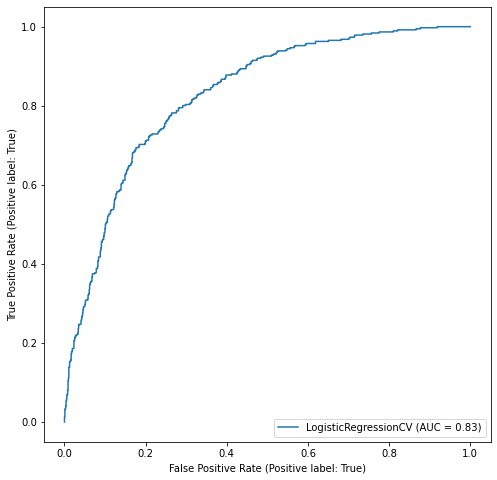

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(log_reg,log_x_test,y_test,ax=ax)

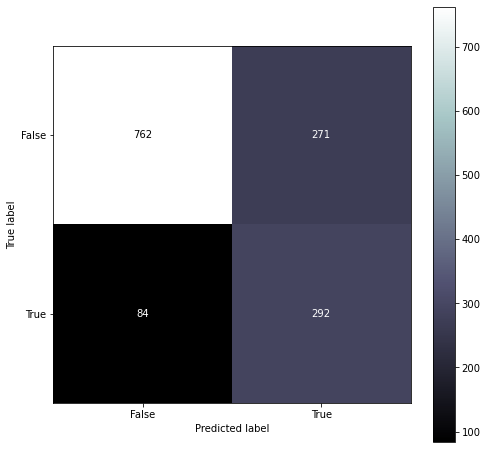

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(log_reg,log_x_test,y_test,cmap='bone',ax=ax)

# K Nearest Neighbors

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [70]:
knn = KNeighborsClassifier()

In [84]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
gsCv = GridSearchCV(knn,{'n_neighbors':[20,30,40,50,60]},scoring='roc_auc',cv=kfold)

In [85]:
gsCv.fit(log_x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1337, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [20, 30, 35, 40, 50, 60]},
             scoring='roc_auc')

In [87]:
pd.DataFrame(gsCv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001600,0.003200,0.260233,0.020820,20,{'n_neighbors': 20},0.838930,0.829670,0.833438,0.842996,0.810334,0.831074,0.011328,6
1,0.004357,0.003125,0.249548,0.016477,30,{'n_neighbors': 30},0.842365,0.836310,0.836530,0.848253,0.814409,0.835573,0.011457,5
2,0.001557,0.001912,0.240394,0.008330,35,{'n_neighbors': 35},0.844708,0.836785,0.837322,0.852161,0.815694,0.837334,0.012189,4
3,0.003400,0.003723,0.231487,0.010419,40,{'n_neighbors': 40},0.845190,0.838837,0.841381,0.853616,0.815983,0.839002,0.012549,3
4,0.000000,0.000000,0.248085,0.014699,50,{'n_neighbors': 50},0.845922,0.839909,0.844306,0.854596,0.820883,0.841123,0.011187,1
5,0.000000,0.000000,0.235919,0.022111,60,{'n_neighbors': 60},0.846113,0.838461,0.843435,0.854721,0.820456,0.840637,0.011386,2


In [56]:
pd.DataFrame(log_x_train[fold[0]].todense(),columns=log_pipe.get_feature_names_out())

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.350268,-1.505296,-0.812661,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.280614,0.539406,1.255718,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.220541,-1.488632,-0.683023,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.676444,-1.505296,-0.879358,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.606791,1.070995,2.125354,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503,-1.124937,0.999339,-0.808134,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4504,-0.064863,0.354433,0.058321,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4505,-0.676444,-0.513774,-0.659635,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4506,-0.268724,-1.501963,-0.810563,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
